***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-3.2)** 32D>16D>8D (Coarse>Medium>FINE) use skip connections between Secondary Capsules $Concatenate([P_{caps}, S_{coarse}])$ > input for $S_{medium}$ and $Concatenate([P_{caps}, S_{medium}])$ > input for $S_{fine}$
- Without $L_{Cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD\Training_and_Analysis\3_CIFAR-10
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "1" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  1
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
directory = sysenv.log_dir('3_CIFAR_10/HD_CapsNet/HD_CapsNet_WO-Lc')

FOLDER CREATED =  ../../logs/3_CIFAR_10/HD_CapsNet/Mod_3_2


# Import Dataset : CIFAR-10

In [5]:
dataset = datasets.CIFAR10(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR10(version = 'reduce') # importing CIFAR10 Dataset

CIFAR-10 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")
    return total_marginloss

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F):
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*margin_loss(y_true_m, y_pred_m)
    ML_f = LW_F*margin_loss(y_true_f, y_pred_f)
    batch_loss = ML_c + ML_m+ ML_f
    return tf.reduce_mean(batch_loss)

## Model Architecture

In [10]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = 2
    no_medium_class = 7
    no_fine_class = 10

    PCap_n_dims = 8

    SCap_f_dims = 8
    SCap_m_dims = 16
    SCap_c_dims = 32


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    reshapec = keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims),
                                     PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(p_caps)
    
    ## Skip Connection: For Medium Level
    p_caps_m = keras.layers.Reshape((int((tf.reduce_prod(p_caps.shape[1:]).numpy())/s_caps_c.shape[-1]),
                                     s_caps_c.shape[-1]), name="primary_skip_m")(p_caps)
    skip_m = keras.layers.Concatenate(axis=1)([p_caps_m, s_caps_c])

    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(skip_m)
    
    ## Skip Connection: For Fine Level
    p_caps_f = keras.layers.Reshape((int((tf.reduce_prod(p_caps.shape[1:]).numpy())/s_caps_m.shape[-1]),
                                     s_caps_m.shape[-1]), name="primary_skip_f")(p_caps)
    skip_f = keras.layers.Concatenate(axis=1)([p_caps_f, s_caps_m])

    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(skip_f)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')
    
    ## Saving Model Architecture
    keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [11]:
model = get_compiled_model()

In [12]:
model.summary()

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 prediction_medium (LengthLayer  (None, 7)           0           ['s_caps_medium[0][0]']          
 )                                                                                                
                                                                                                  
 prediction_fine (LengthLayer)  (None, 10)           0           ['s_caps_fine[0][0]']            
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 2)            0           ['prediction_coarse[0][0]']      
                                                                                                  
 tf.math.subtract_1 (TFOpLambda  (None, 2)           0           ['prediction_coarse[0][0]']      
 )                                                                                                
          

 tf.math.multiply_8 (TFOpLambda  (None, 10)          0           ['input_yf[0][0]',               
 )                                                                'tf.math.square_4[0][0]']       
                                                                                                  
 tf.math.multiply_10 (TFOpLambd  (None, 10)          0           ['tf.math.multiply_9[0][0]',     
 a)                                                               'tf.math.square_5[0][0]']       
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None,)             0           ['tf.math.add[0][0]']            
 )                                                                                                
                                                                                                  
 tf.math.reduce_sum_1 (TFOpLamb  (None,)             0           ['tf.math.add_1[0][0]']          
 da)      

## Data Augmentation

In [13]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [14]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [15]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.2296 - prediction_coarse_accuracy: 0.8815 - prediction_medium_accuracy: 0.5999 - prediction_fine_accuracy: 0.4695
  • Coarse Accuracy = 88.15% | Val_Accuracy = 91.53% | LossWeight = 0.17 
  • Medium Accuracy = 59.99% | Val_Accuracy = 69.22% | LossWeight = 0.41 
  • Fine   Accuracy = 46.95% | Val_Accuracy = 59.77% | LossWeight = 0.41 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.59770, saving model to ../../logs/3_CIFAR_10/HD_CapsNet/Mod_3_2\epoch-best.h5
781/781 [==============================] - 54s 59ms/step - loss: 0.2296 - prediction_coarse_accuracy: 0.8815 - prediction_medium_accuracy: 0.5999 - prediction_fine_accuracy: 0.4695 - val_loss: 0.1646 - val_prediction_coarse_accuracy: 0.9153 - val_prediction_medium_accuracy: 0.6922 - val_prediction_fine_accuracy: 0.5977 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.1434 - prediction_coarse_accuracy: 0.9293 -

781/781 [==============================] - 46s 59ms/step - loss: 0.0808 - prediction_coarse_accuracy: 0.9688 - prediction_medium_accuracy: 0.9051 - prediction_fine_accuracy: 0.8697 - val_loss: 0.0530 - val_prediction_coarse_accuracy: 0.9773 - val_prediction_medium_accuracy: 0.8935 - val_prediction_fine_accuracy: 0.8574 - lr: 0.0010
Epoch 10/100
781/781 [==============================] - ETA: 0s - loss: 0.0785 - prediction_coarse_accuracy: 0.9708 - prediction_medium_accuracy: 0.9111 - prediction_fine_accuracy: 0.8789
  • Coarse Accuracy = 97.08% | Val_Accuracy = 98.02% | LossWeight = 0.19 
  • Medium Accuracy = 91.11% | Val_Accuracy = 89.81% | LossWeight = 0.40 
  • Fine   Accuracy = 87.89% | Val_Accuracy = 85.95% | LossWeight = 0.41 

Epoch 10: val_prediction_fine_accuracy improved from 0.85740 to 0.85950, saving model to ../../logs/3_CIFAR_10/HD_CapsNet/Mod_3_2\epoch-best.h5
781/781 [==============================] - 46s 59ms/step - loss: 0.0785 - prediction_coarse_accuracy: 0.9708 - 

Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.0623 - prediction_coarse_accuracy: 0.9798 - prediction_medium_accuracy: 0.9477 - prediction_fine_accuracy: 0.9304
  • Coarse Accuracy = 97.98% | Val_Accuracy = 98.53% | LossWeight = 0.21 
  • Medium Accuracy = 94.77% | Val_Accuracy = 91.92% | LossWeight = 0.39 
  • Fine   Accuracy = 93.04% | Val_Accuracy = 88.69% | LossWeight = 0.39 

Epoch 19: val_prediction_fine_accuracy did not improve from 0.88780
781/781 [==============================] - 46s 59ms/step - loss: 0.0623 - prediction_coarse_accuracy: 0.9798 - prediction_medium_accuracy: 0.9477 - prediction_fine_accuracy: 0.9304 - val_loss: 0.0417 - val_prediction_coarse_accuracy: 0.9853 - val_prediction_medium_accuracy: 0.9192 - val_prediction_fine_accuracy: 0.8869 - lr: 6.3025e-04
Epoch 20/100
781/781 [==============================] - ETA: 0s - loss: 0.0612 - prediction_coarse_accuracy: 0.9802 - prediction_medium_accuracy: 0.9500 - prediction_fine_accuracy: 0.

781/781 [==============================] - 46s 59ms/step - loss: 0.0574 - prediction_coarse_accuracy: 0.9815 - prediction_medium_accuracy: 0.9585 - prediction_fine_accuracy: 0.9489 - val_loss: 0.0390 - val_prediction_coarse_accuracy: 0.9839 - val_prediction_medium_accuracy: 0.9292 - val_prediction_fine_accuracy: 0.8956 - lr: 3.9721e-04
Epoch 29/100
780/781 [============================>.] - ETA: 0s - loss: 0.0572 - prediction_coarse_accuracy: 0.9827 - prediction_medium_accuracy: 0.9596 - prediction_fine_accuracy: 0.9503
  • Coarse Accuracy = 98.27% | Val_Accuracy = 98.33% | LossWeight = 0.24 
  • Medium Accuracy = 95.96% | Val_Accuracy = 92.69% | LossWeight = 0.40 
  • Fine   Accuracy = 95.03% | Val_Accuracy = 89.44% | LossWeight = 0.36 

Epoch 29: val_prediction_fine_accuracy did not improve from 0.89560
781/781 [==============================] - 46s 59ms/step - loss: 0.0572 - prediction_coarse_accuracy: 0.9827 - prediction_medium_accuracy: 0.9596 - prediction_fine_accuracy: 0.9503 - 

Epoch 38/100
781/781 [==============================] - ETA: 0s - loss: 0.0554 - prediction_coarse_accuracy: 0.9829 - prediction_medium_accuracy: 0.9627 - prediction_fine_accuracy: 0.9549
  • Coarse Accuracy = 98.29% | Val_Accuracy = 98.57% | LossWeight = 0.25 
  • Medium Accuracy = 96.27% | Val_Accuracy = 93.27% | LossWeight = 0.39 
  • Fine   Accuracy = 95.49% | Val_Accuracy = 90.14% | LossWeight = 0.36 

Epoch 38: val_prediction_fine_accuracy did not improve from 0.90360
781/781 [==============================] - 46s 59ms/step - loss: 0.0554 - prediction_coarse_accuracy: 0.9829 - prediction_medium_accuracy: 0.9627 - prediction_fine_accuracy: 0.9549 - val_loss: 0.0368 - val_prediction_coarse_accuracy: 0.9857 - val_prediction_medium_accuracy: 0.9327 - val_prediction_fine_accuracy: 0.9014 - lr: 2.3783e-04
Epoch 39/100
781/781 [==============================] - ETA: 0s - loss: 0.0554 - prediction_coarse_accuracy: 0.9842 - prediction_medium_accuracy: 0.9635 - prediction_fine_accuracy: 0.

781/781 [==============================] - 47s 60ms/step - loss: 0.0539 - prediction_coarse_accuracy: 0.9843 - prediction_medium_accuracy: 0.9658 - prediction_fine_accuracy: 0.9593 - val_loss: 0.0351 - val_prediction_coarse_accuracy: 0.9864 - val_prediction_medium_accuracy: 0.9354 - val_prediction_fine_accuracy: 0.9053 - lr: 1.4989e-04
Epoch 48/100
781/781 [==============================] - ETA: 0s - loss: 0.0542 - prediction_coarse_accuracy: 0.9833 - prediction_medium_accuracy: 0.9651 - prediction_fine_accuracy: 0.9597
  • Coarse Accuracy = 98.33% | Val_Accuracy = 98.56% | LossWeight = 0.27 
  • Medium Accuracy = 96.51% | Val_Accuracy = 93.72% | LossWeight = 0.39 
  • Fine   Accuracy = 95.97% | Val_Accuracy = 90.82% | LossWeight = 0.34 

Epoch 48: val_prediction_fine_accuracy improved from 0.90640 to 0.90820, saving model to ../../logs/3_CIFAR_10/HD_CapsNet/Mod_3_2\epoch-best.h5
781/781 [==============================] - 46s 59ms/step - loss: 0.0542 - prediction_coarse_accuracy: 0.983

Epoch 57/100
781/781 [==============================] - ETA: 0s - loss: 0.0528 - prediction_coarse_accuracy: 0.9850 - prediction_medium_accuracy: 0.9680 - prediction_fine_accuracy: 0.9624
  • Coarse Accuracy = 98.50% | Val_Accuracy = 98.58% | LossWeight = 0.26 
  • Medium Accuracy = 96.80% | Val_Accuracy = 93.58% | LossWeight = 0.39 
  • Fine   Accuracy = 96.24% | Val_Accuracy = 90.65% | LossWeight = 0.35 

Epoch 57: val_prediction_fine_accuracy did not improve from 0.90860
781/781 [==============================] - 46s 59ms/step - loss: 0.0528 - prediction_coarse_accuracy: 0.9850 - prediction_medium_accuracy: 0.9680 - prediction_fine_accuracy: 0.9624 - val_loss: 0.0344 - val_prediction_coarse_accuracy: 0.9858 - val_prediction_medium_accuracy: 0.9358 - val_prediction_fine_accuracy: 0.9065 - lr: 8.9745e-05
Epoch 58/100
781/781 [==============================] - ETA: 0s - loss: 0.0541 - prediction_coarse_accuracy: 0.9843 - prediction_medium_accuracy: 0.9667 - prediction_fine_accuracy: 0.

781/781 [==============================] - ETA: 0s - loss: 0.0534 - prediction_coarse_accuracy: 0.9862 - prediction_medium_accuracy: 0.9677 - prediction_fine_accuracy: 0.9619
  • Coarse Accuracy = 98.62% | Val_Accuracy = 98.69% | LossWeight = 0.24 
  • Medium Accuracy = 96.77% | Val_Accuracy = 93.98% | LossWeight = 0.40 
  • Fine   Accuracy = 96.19% | Val_Accuracy = 91.02% | LossWeight = 0.35 

Epoch 66: val_prediction_fine_accuracy improved from 0.91000 to 0.91020, saving model to ../../logs/3_CIFAR_10/HD_CapsNet/Mod_3_2\epoch-best.h5
781/781 [==============================] - 46s 59ms/step - loss: 0.0534 - prediction_coarse_accuracy: 0.9862 - prediction_medium_accuracy: 0.9677 - prediction_fine_accuracy: 0.9619 - val_loss: 0.0328 - val_prediction_coarse_accuracy: 0.9869 - val_prediction_medium_accuracy: 0.9398 - val_prediction_fine_accuracy: 0.9102 - lr: 5.6562e-05
Epoch 67/100
781/781 [==============================] - ETA: 0s - loss: 0.0520 - prediction_coarse_accuracy: 0.9846 - pr

781/781 [==============================] - 47s 60ms/step - loss: 0.0527 - prediction_coarse_accuracy: 0.9856 - prediction_medium_accuracy: 0.9676 - prediction_fine_accuracy: 0.9632 - val_loss: 0.0328 - val_prediction_coarse_accuracy: 0.9871 - val_prediction_medium_accuracy: 0.9376 - val_prediction_fine_accuracy: 0.9066 - lr: 3.5648e-05
Epoch 76/100
781/781 [==============================] - ETA: 0s - loss: 0.0527 - prediction_coarse_accuracy: 0.9848 - prediction_medium_accuracy: 0.9667 - prediction_fine_accuracy: 0.9610
  • Coarse Accuracy = 98.48% | Val_Accuracy = 98.76% | LossWeight = 0.26 
  • Medium Accuracy = 96.67% | Val_Accuracy = 93.87% | LossWeight = 0.40 
  • Fine   Accuracy = 96.10% | Val_Accuracy = 90.82% | LossWeight = 0.35 

Epoch 76: val_prediction_fine_accuracy did not improve from 0.91060
781/781 [==============================] - 46s 59ms/step - loss: 0.0527 - prediction_coarse_accuracy: 0.9848 - prediction_medium_accuracy: 0.9667 - prediction_fine_accuracy: 0.9610 - 

781/781 [==============================] - ETA: 0s - loss: 0.0525 - prediction_coarse_accuracy: 0.9838 - prediction_medium_accuracy: 0.9667 - prediction_fine_accuracy: 0.9623
  • Coarse Accuracy = 98.38% | Val_Accuracy = 98.73% | LossWeight = 0.27 
  • Medium Accuracy = 96.67% | Val_Accuracy = 93.91% | LossWeight = 0.39 
  • Fine   Accuracy = 96.23% | Val_Accuracy = 91.02% | LossWeight = 0.33 

Epoch 85: val_prediction_fine_accuracy did not improve from 0.91060
781/781 [==============================] - 47s 60ms/step - loss: 0.0525 - prediction_coarse_accuracy: 0.9838 - prediction_medium_accuracy: 0.9667 - prediction_fine_accuracy: 0.9623 - val_loss: 0.0324 - val_prediction_coarse_accuracy: 0.9873 - val_prediction_medium_accuracy: 0.9391 - val_prediction_fine_accuracy: 0.9102 - lr: 2.1344e-05
Epoch 86/100
781/781 [==============================] - ETA: 0s - loss: 0.0539 - prediction_coarse_accuracy: 0.9850 - prediction_medium_accuracy: 0.9673 - prediction_fine_accuracy: 0.9626
  • Coar

781/781 [==============================] - 43s 55ms/step - loss: 0.0524 - prediction_coarse_accuracy: 0.9859 - prediction_medium_accuracy: 0.9679 - prediction_fine_accuracy: 0.9640 - val_loss: 0.0325 - val_prediction_coarse_accuracy: 0.9874 - val_prediction_medium_accuracy: 0.9386 - val_prediction_fine_accuracy: 0.9084 - lr: 1.3452e-05
Epoch 95/100
780/781 [============================>.] - ETA: 0s - loss: 0.0524 - prediction_coarse_accuracy: 0.9846 - prediction_medium_accuracy: 0.9669 - prediction_fine_accuracy: 0.9616
  • Coarse Accuracy = 98.46% | Val_Accuracy = 98.71% | LossWeight = 0.26 
  • Medium Accuracy = 96.69% | Val_Accuracy = 93.99% | LossWeight = 0.39 
  • Fine   Accuracy = 96.15% | Val_Accuracy = 90.97% | LossWeight = 0.34 

Epoch 95: val_prediction_fine_accuracy did not improve from 0.91060
781/781 [==============================] - 43s 56ms/step - loss: 0.0524 - prediction_coarse_accuracy: 0.9846 - prediction_medium_accuracy: 0.9669 - prediction_fine_accuracy: 0.9615 - 

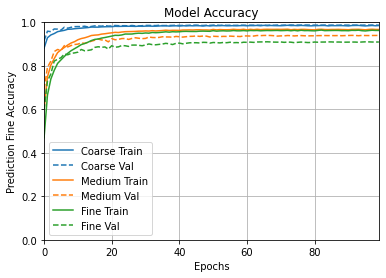

In [16]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

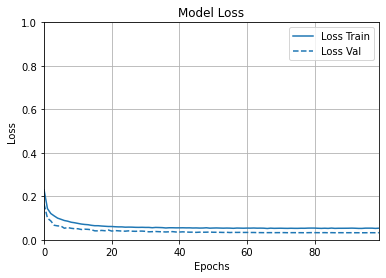

In [17]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

## Model Analysis

In [18]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 7s 15ms/step - loss: 0.0436 - prediction_coarse_loss: 0.0101 - prediction_medium_loss: 0.0443 - prediction_fine_loss: 0.0677 - prediction_coarse_accuracy: 0.9871 - prediction_medium_accuracy: 0.9401 - prediction_fine_accuracy: 0.9097
1. loss ==> 0.043589212000370026
2. prediction_coarse_loss ==> 0.010057088918983936
3. prediction_medium_loss ==> 0.04434972628951073
4. prediction_fine_loss ==> 0.06772300601005554
5. prediction_coarse_accuracy ==> 0.9871000051498413
6. prediction_medium_accuracy ==> 0.9401000142097473
7. prediction_fine_accuracy ==> 0.9096999764442444
313/313 [==============================] - 4s 10ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

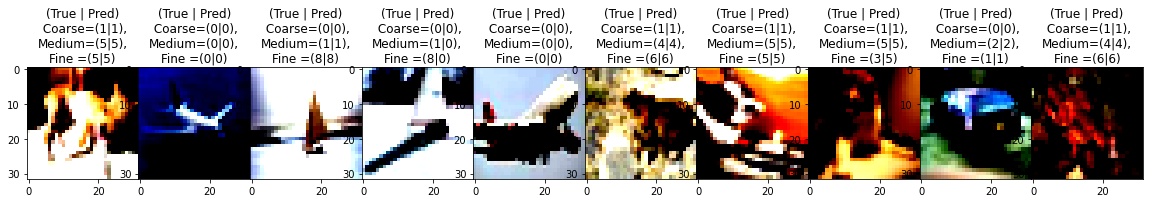

In [19]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[3943   57]
 [  72 5928]]

  • MEDIUM LEVEL 
[[ 951   12   10   14    2    7    4]
 [  30  942   17    4    1    4    2]
 [  15   11 1965    1    1    3    4]
 [  30    2    1  875   19   43   30]
 [   4    1    4   12  950   24    5]
 [  13    2   12   39   36 1843   55]
 [   8    1    4   30   18   64 1875]]

  • FINE LEVEL 
[[951   3  14   3   0   3   2   5  13   6]
 [  6 958   0   0   1   0   0   0   7  28]
 [ 29   1 880  21  15  18  20  14   2   0]
 [ 13   3  26 781  25 102  31  10   3   6]
 [  3   1  24  18 908  12  20  11   2   1]
 [  3   1  18 104  17 840  11   5   0   1]
 [  4   1  12  15   3   5 956   1   1   2]
 [  5   0  11   7  21  19   1 934   0   2]
 [ 29  10   4   2   1   0   1   2 945   6]
 [ 11  32   1   3   1   1   1   0   6 944]]

  • Classification Report 


  • COARSE LEVEL 


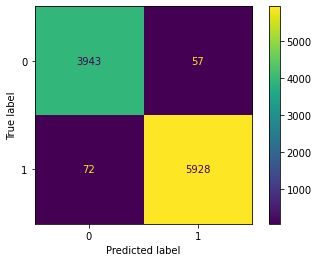

              precision    recall  f1-score   support

           0    0.98207   0.98575   0.98391      4000
           1    0.99048   0.98800   0.98924      6000

    accuracy                        0.98710     10000
   macro avg    0.98627   0.98687   0.98657     10000
weighted avg    0.98711   0.98710   0.98710     10000


  • MEDIUM LEVEL 


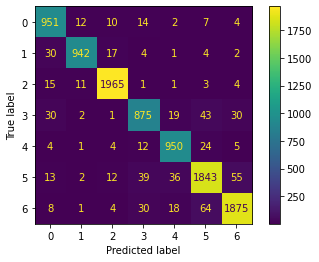

              precision    recall  f1-score   support

           0    0.90485   0.95100   0.92735      1000
           1    0.97013   0.94200   0.95586      1000
           2    0.97615   0.98250   0.97932      2000
           3    0.89744   0.87500   0.88608      1000
           4    0.92502   0.95000   0.93735      1000
           5    0.92706   0.92150   0.92427      2000
           6    0.94937   0.93750   0.94340      2000

    accuracy                        0.94010     10000
   macro avg    0.93572   0.93707   0.93623     10000
weighted avg    0.94026   0.94010   0.94006     10000


  • FINE LEVEL 


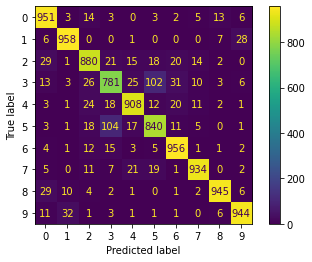

              precision    recall  f1-score   support

           0    0.90228   0.95100   0.92600      1000
           1    0.94851   0.95800   0.95323      1000
           2    0.88889   0.88000   0.88442      1000
           3    0.81866   0.78100   0.79939      1000
           4    0.91532   0.90800   0.91165      1000
           5    0.84000   0.84000   0.84000      1000
           6    0.91659   0.95600   0.93588      1000
           7    0.95112   0.93400   0.94248      1000
           8    0.96527   0.94500   0.95503      1000
           9    0.94779   0.94400   0.94589      1000

    accuracy                        0.90970     10000
   macro avg    0.90944   0.90970   0.90940     10000
weighted avg    0.90944   0.90970   0.90940     10000



In [20]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [21]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.9453383333333333 
Hierarchical Recall = 0.9473 
Hierarchical F1-Score = 0.9461547619047619 
Consistency =  0.9899 
Exact Match =  0.9058
